In [289]:
# Use GPU
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [290]:
import pandas as pd

pd.set_option('display.max_columns',150)

data_path = './data/'
train = 'train.csv'
test = 'test.csv'
example_submission = 'gender_submission.csv'

train_file = os.path.join(data_path,train)
test_file = os.path.join(data_path,test)

In [291]:
# read the data
df = pd.read_csv(train_file)

In [292]:
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [293]:
# some basic cleaning/encoding

# drop id column
df.drop(columns=['PassengerId'],inplace=True)

# categorically encode the Pclass (ticket class column)
df['Pclass'] = df['Pclass'].astype('category').cat.codes

# one-hot encode the sex column
df = pd.get_dummies(df, columns = ['Sex'], drop_first=True)

df.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,0,2,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,True
1,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,False
2,1,2,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,False
4,0,2,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,True


In [294]:
# check out the missing embarked values
missing_embarked = df[df['Embarked'].isna()]
missing_embarked

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
61,1,0,"Icard, Miss. Amelie",38.0,0,0,113572,80.0,B28,NaN,False
829,1,0,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,0,0,113572,80.0,B28,NaN,False


In [295]:
# perhaps the missing embarked people never boarded? thus its why they survived? we will drop those
df.dropna(subset=['Embarked'],inplace=True)
df['Embarked'].isna().sum()

0

In [296]:
# encode the embarked column, there is inherent order regarding the order of ports
# southhampton -> Cherbourg -> queenstown
port_mapping = {
  'Q': 2,
  'C': 1,
  'S': 0,
}

df['Embarked'] = df['Embarked'].map(port_mapping)
df.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,0,2,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,True
1,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,False
2,1,2,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,False
3,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,False
4,0,2,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,True


In [297]:
# extract the titles from names. can use as a feature for names
titles = df['Name'].str.extract(r',\s*([a-zA-Z]+\.)',expand=False)
titles.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', nan,
       'Jonkheer.'], dtype=object)

In [298]:
# check out the missing title
df['Title'] = df['Name'].str.extract(r',\s*([a-zA-Z]+\.)',expand=False)
df[df['Title'].isna()]

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male,Title
759,1,0,"Rothes, the Countess. of (Lucy Noel Martha Dye...",33.0,0,0,110152,86.5,B77,0,False,NaN


In [299]:
male_titles = ['Mr.', 'Don.', 'Sir.', 'Master.']
female_married = ['Mrs.', 'Mme.', 'Lady.', 'Countess.']
female_other = ['Miss.', 'Ms.', 'Mlle.', 'Jonkheer.']
religious_titles = ['Rev.']
professional_title = ['Dr.']
military_titles = ['Major.', 'Capt.', 'Col.',]

titles = {
  'male': male_titles, 
  'female married': female_married,
  'female other': female_other,
  'religious': religious_titles,
  'professional': professional_title,
  'military': military_titles
}

def get_category(x):
  for type_, l in titles.items():
    if x in l:
      return type_
  return "Other"
  
df.loc[759, 'Title'] = 'Mrs.'

df['Title'] = df['Title'].apply(get_category)
df = pd.get_dummies(df, columns=['Title'])
df.drop(columns=['Name'],inplace=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male,Title_female married,Title_female other,Title_male,Title_military,Title_professional,Title_religious
0,0,2,22.0,1,0,A/5 21171,7.2500,NaN,0,True,False,False,True,False,False,False
1,1,0,38.0,1,0,PC 17599,71.2833,C85,1,False,True,False,False,False,False,False
2,1,2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,False,False,True,False,False,False,False
3,1,0,35.0,1,0,113803,53.1000,C123,0,False,True,False,False,False,False,False
4,0,2,35.0,0,0,373450,8.0500,NaN,0,True,False,False,True,False,False,False


<Axes: xlabel='Age', ylabel='Count'>

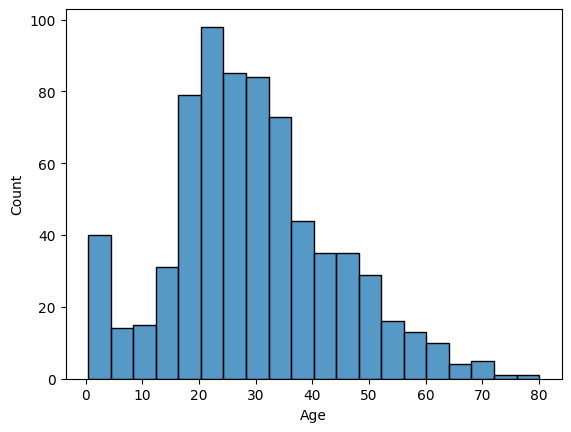

In [300]:
# check age distribution
import seaborn as sns
ages = df['Age']
sns.histplot(ages)

0


<Axes: xlabel='Age', ylabel='Count'>

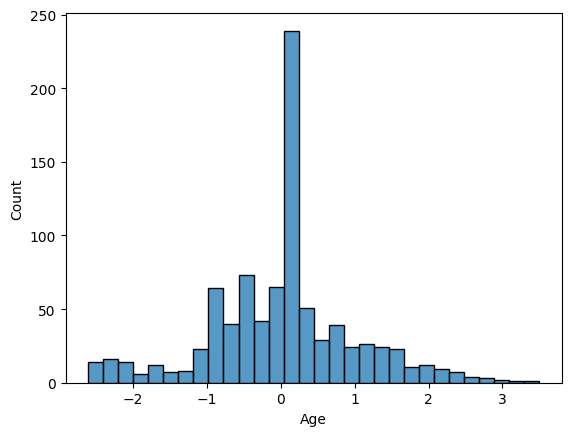

In [301]:
# impute missing ages with mean ages
df['Age'] = df['Age'].fillna(df['Age'].mean())
print(df['Age'].isna().sum())

from sklearn.preprocessing import PowerTransformer, StandardScaler
age_scaler = PowerTransformer('box-cox')
age_scaler.fit(df[['Age']].values.tolist())
df['Age'] = age_scaler.transform(df[['Age']].values.tolist())
sns.histplot(df['Age'])

198.67818039875826


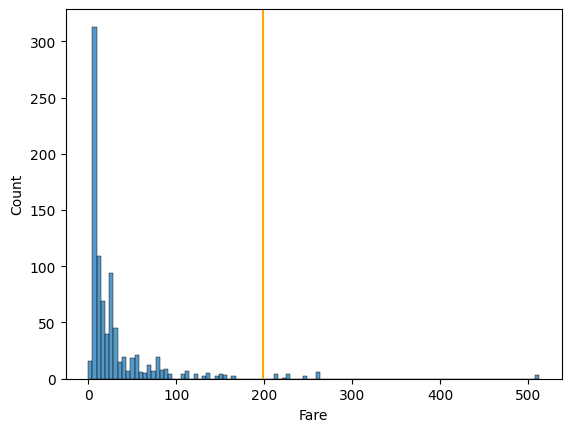

In [302]:
# handle the fare, trim extreme outliers
import numpy as np
import matplotlib.pyplot as plt
fares = df['Fare'].values
fare_mean, fare_std = np.mean(fares), np.std(fares)
cut_off = fare_std * 4
print(cut_off)
sns.histplot(df['Fare'])
plt.axvline(cut_off, color='orange')

<Axes: xlabel='Fare', ylabel='Count'>

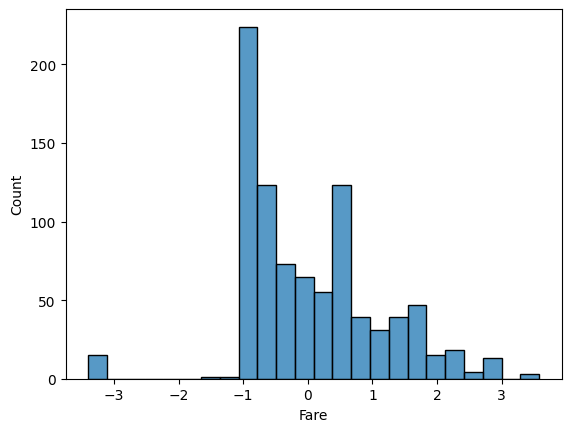

In [303]:
# heavy right skew on the fare so we'll use a power transformer
fare_scaler = PowerTransformer()
fare_scaler.fit(df[df['Fare'] <= cut_off][['Fare']].values.tolist())
df['Fare'] =  fare_scaler.transform(df[['Fare']].values)
sns.histplot(df['Fare'])

Ticket Prefix
Num           659
PC             60
C.A.           28
C              24
A/5            17
CA             14
STON/O         12
W./C.           9
SOTON/O.Q.      8
SOTON/OQ        7
PP              7
STON/O2.        6
S.O.C.          5
SC/Paris        4
LINE            4
A/4.            3
A/4             3
S.O./P.P.       3
WE/P            2
SOTON/O2        2
A.5.            2
A./5.           2
SO/C            1
S.P.            1
S.C./A.4.       1
W.E.P.          1
S.O.P.          1
A4.             1
A/S             1
Fa              1
Name: count, dtype: int64
Survived
0.000000    14
0.500000     4
0.111111     1
0.117647     1
0.125000     1
0.071429     1
0.142857     1
0.250000     1
0.416667     1
0.382398     1
0.464286     1
0.650000     1
0.714286     1
1.000000     1
Name: count, dtype: int64


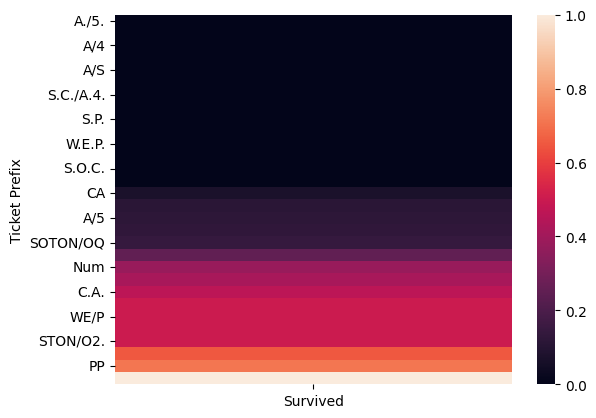

In [304]:
# take a look at tickets
boolean = df['Ticket'].str.contains('[a-zA-Z]', regex=True)
values = df.loc[boolean]['Ticket'].str.split(r'[\s\n]')
ticket_prefixes = values.apply(lambda x: x[0]).values.tolist()

def ticket_prefix_clean(x):
  for ticket_prefix in ticket_prefixes:
    if ticket_prefix in x:
      return ticket_prefix
    
  return "Num"

df['Ticket Prefix'] = df['Ticket'].apply(ticket_prefix_clean)

print(df['Ticket Prefix'].value_counts())

pivot_data = pd.pivot_table(data=df[['Ticket Prefix', 'Survived']], values='Survived', index='Ticket Prefix', aggfunc='mean').sort_values('Survived')

print(pivot_data.value_counts())
sns.heatmap(pivot_data)

df.drop(columns=['Ticket', 'Ticket Prefix'], inplace=True)

['Mis' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


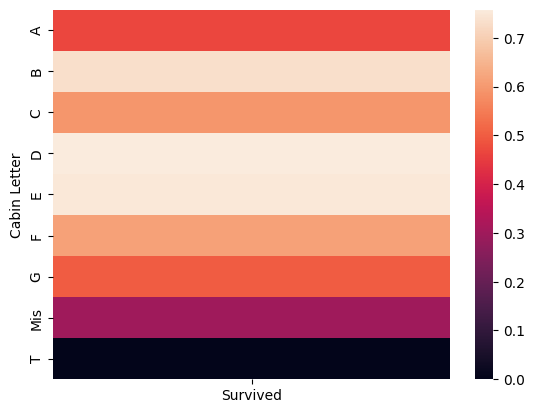

In [305]:
# analyze the cabins
cabin_letters = df['Cabin'].str.extract(r'([A-Z])',expand=False).fillna("Mis")
df['Cabin Letter'] = cabin_letters


corr = df[['Survived', 'Cabin Letter']]

print(corr['Cabin Letter'].unique())

import seaborn as sns
pivot_data = pd.pivot_table(corr, values='Survived', index='Cabin Letter', aggfunc='mean').sort_values(by='Cabin Letter')
sns.heatmap(pivot_data)

df.drop(columns=['Cabin', 'Cabin Letter'], inplace=True)

In [306]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_male,Title_female married,Title_female other,Title_male,Title_military,Title_professional,Title_religious
0,0,2,-0.550779,1,0,-0.883359,0,True,False,False,True,False,False,False
1,1,0,0.662413,1,0,1.534500,1,False,True,False,False,False,False,False
2,1,2,-0.236038,0,0,-0.792816,0,False,False,True,False,False,False,False
3,1,0,0.443203,1,0,1.221230,0,False,True,False,False,False,False,False
4,0,2,0.443203,0,0,-0.776827,0,True,False,False,True,False,False,False


<Axes: xlabel='SibSp', ylabel='Count'>

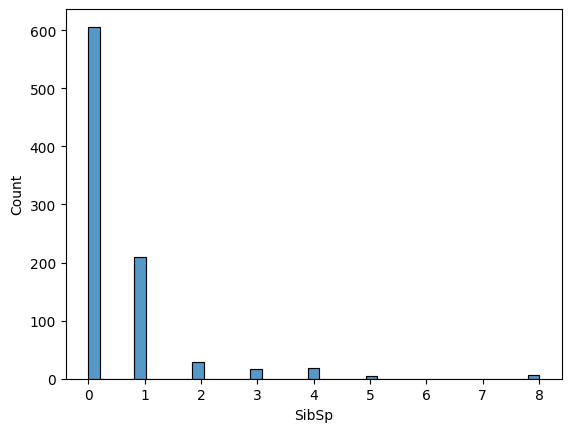

In [307]:
# handle sibsp and parch columns
sns.histplot(df['SibSp'])

In [308]:
df = df[df['SibSp'] < 6]

<Axes: xlabel='Parch', ylabel='Count'>

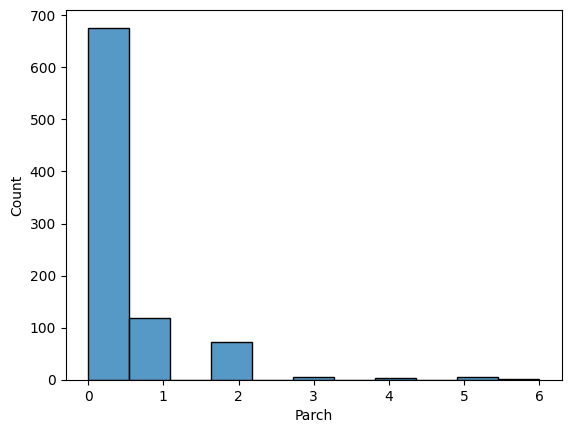

In [309]:
sns.histplot(df['Parch'])

In [310]:
df = df[df['Parch'] < 6]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 881 entries, 0 to 890
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Survived              881 non-null    int64  
 1   Pclass                881 non-null    int8   
 2   Age                   881 non-null    float64
 3   SibSp                 881 non-null    int64  
 4   Parch                 881 non-null    int64  
 5   Fare                  881 non-null    float64
 6   Embarked              881 non-null    int64  
 7   Sex_male              881 non-null    bool   
 8   Title_female married  881 non-null    bool   
 9   Title_female other    881 non-null    bool   
 10  Title_male            881 non-null    bool   
 11  Title_military        881 non-null    bool   
 12  Title_professional    881 non-null    bool   
 13  Title_religious       881 non-null    bool   
dtypes: bool(7), float64(2), int64(4), int8(1)
memory usage: 55.1 KB


In [311]:
from sklearn.preprocessing import MinMaxScaler
sibling_scaler = MinMaxScaler()
sibling_scaler.fit(df[['SibSp']].values)

parent_scaler = MinMaxScaler()
parent_scaler.fit(df[['Parch']].values)

df['SibSp'] = sibling_scaler.transform(df[['SibSp']])
df['Parch'] = parent_scaler.transform(df[['Parch']])

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [312]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_male,Title_female married,Title_female other,Title_male,Title_military,Title_professional,Title_religious
0,0,2,-0.550779,0.2,0.0,-0.883359,0,True,False,False,True,False,False,False
1,1,0,0.662413,0.2,0.0,1.534500,1,False,True,False,False,False,False,False
2,1,2,-0.236038,0.0,0.0,-0.792816,0,False,False,True,False,False,False,False
3,1,0,0.443203,0.2,0.0,1.221230,0,False,True,False,False,False,False,False
4,0,2,0.443203,0.0,0.0,-0.776827,0,True,False,False,True,False,False,False
